In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.2.2'

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)

import constants
imp.reload(constants)
from constants import *

# Vary 1 waveform parameter with dense sampling

Make sure none of the parameters have "special" values such as q=1 or lambda1=lambda2.

In [4]:
q = 0.6
spin1z_arr = np.linspace(-0.5, 0.5, 51)
spin2z = 0.2
lambda1 = 2000.0
lambda2 = 1000.0
params = np.array([[q, spin1z, spin2z, lambda1, lambda2] for spin1z in spin1z_arr])

In [5]:
header = """51 points. Only S1 is varied.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/params_testset1d_S1.txt', params,
#           header=header)

# Initial training set parameters

In [6]:
def uniform_grid(n, limits):
    """This is really stupid.
    """
    points = []
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        #print point
                        points.append(point)
    #print points
    return np.array(points)

In [8]:
# Parameters for the training set

limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
corners = uniform_grid(2, limits)

Ndata = 128
lhd = doe.latin_hypercube(Ndata, limits)

params = np.concatenate((corners, lhd))

params.shape

(160, 5)

Text(0.5,0,'$\\Lambda_1$')

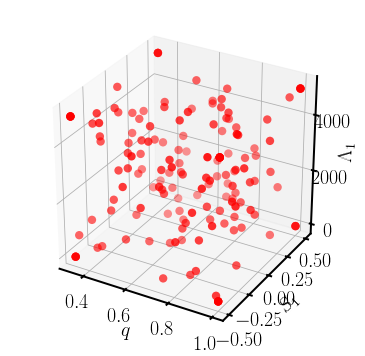

In [9]:
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
x, y, z = params[:, 0], params[:, 1], params[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

In [10]:
header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 32 corners and 128 LHD points.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/params_trainset_corners_lhd.txt', params,
#           header=header)

# xi parameters

In [8]:
# Do coordinate transformation
def lam_of_xi(xi, a=100):
    return a*(10**xi - 1)

def xi_of_lam(lam, a=100):
    return np.log10(lam/a + 1)

# Corners+LHD in xi parameters

In [15]:
ximin = xi_of_lam(0)
ximax = xi_of_lam(5000)
print ximin, ximax
# Parameters for the training set

limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, ximax], [0, ximax]])
corners = uniform_grid(2, limits)

Ndata = 128
lhd = doe.latin_hypercube(Ndata, limits)

params = np.concatenate((corners, lhd))

params[:, 3] = lam_of_xi(params[:, 3])
params[:, 4] = lam_of_xi(params[:, 4])

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 32 corners and 128 LHD points.
Lambda1 and Lambda2 are sampled in xi
"""

# np.savetxt(
#     '/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/params_trainset_corners_lhd_xi.txt', 
#     params, header=header)

0.0 1.7075701760979363


Text(0.5,0,'$\\Lambda_1$')

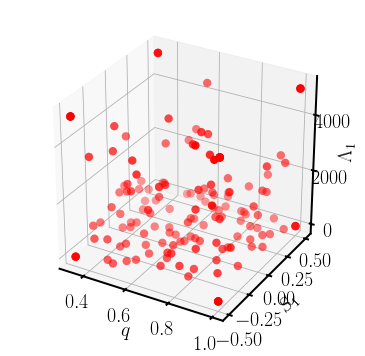

In [16]:
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
x, y, z = params[:, 0], params[:, 1], params[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

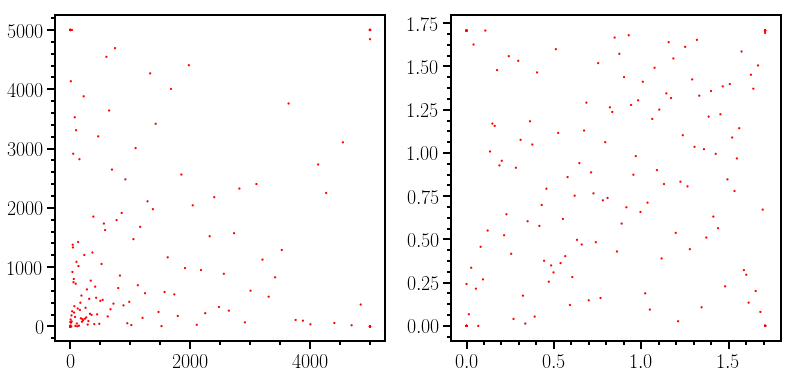

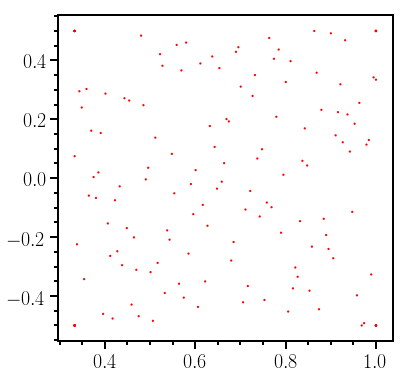

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax1.scatter(params[:, 3], params[:, 4], c='r', edgecolor='none', marker='o', s=5)
#ax1.set_xlim(0, 5000)
#ax1.set_ylim(0, 5000)
ax1.minorticks_on()

ax2.scatter(xi_of_lam(params[:, 3]), xi_of_lam(params[:, 4]), c='r', edgecolor='none', marker='o', s=5)
#ax2.set_xlim(0, 5000)
#ax2.set_ylim(0, 5000)
ax2.minorticks_on()

fig, (ax1) = plt.subplots(figsize=(6, 6))

ax1.scatter(params[:, 0], params[:, 1], c='r', edgecolor='none', marker='o', s=5)
#ax1.set_xlim(0, 5000)
#ax1.set_ylim(0, 5000)
ax1.minorticks_on()

# Uniform in xi(Lambda) parameters

In [25]:
ximin = xi_of_lam(0)
ximax = xi_of_lam(5000)
print ximin, ximax

# Generate the randomly sampled set
Ndata = 500
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, ximax], [0, ximax]])
params = doe.uniform_random_samples(Ndata, limits)

params[:, 3] = lam_of_xi(params[:, 3])
params[:, 4] = lam_of_xi(params[:, 4])

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 500 points. Each parameter is randomly sampled between the limits.
The distribution for the tidal parameters are concentrated near small tidal parameters.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/params_uniformxi.txt', params,
#           header=header)

0.0 1.7075701760979363


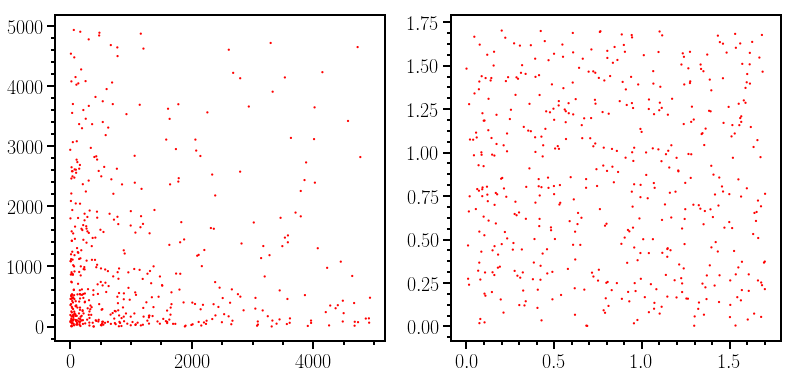

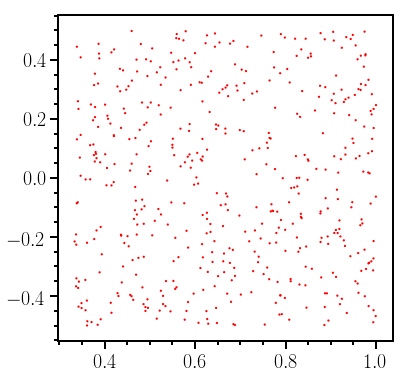

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax1.scatter(params[:, 3], params[:, 4], c='r', edgecolor='none', marker='o', s=5)
#ax1.set_xlim(0, 5000)
#ax1.set_ylim(0, 5000)
ax1.minorticks_on()

ax2.scatter(xi_of_lam(params[:, 3]), xi_of_lam(params[:, 4]), c='r', edgecolor='none', marker='o', s=5)
#ax2.set_xlim(0, 5000)
#ax2.set_ylim(0, 5000)
ax2.minorticks_on()

fig, (ax1) = plt.subplots(figsize=(6, 6))

ax1.scatter(params[:, 0], params[:, 1], c='r', edgecolor='none', marker='o', s=5)
#ax1.set_xlim(0, 5000)
#ax1.set_ylim(0, 5000)
ax1.minorticks_on()

# Randomly sampled parameters

In [ ]:
# Generate the randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
params = doe.uniform_random_samples(Ndata, limits)

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 1000 points. Each parameter is randomly sampled with a uniform distribution between the limits.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/params_testset1.txt', params,
#           header=header)

In [ ]:
# Generate the 2nd randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
params = doe.uniform_random_samples(Ndata, limits)

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]]
There are 1000 points. Each parameter is randomly sampled with a uniform distribution between the limits.
"""
# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/params_testset2.txt', params,
#           header=header)